In [25]:
# 📓 Notebook : Classification multimodale séquentielle CNN + Transformer

# 📦 Imports
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D,
    TimeDistributed, Concatenate, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
import json


In [26]:
def features_exist(path_list):
    return all(os.path.exists(p) for p in path_list)


In [27]:

# --- Dossiers (à adapter)
image_dir_le = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Low energy images of CDD-CESM'
image_dir_sub = 'CDD-CESM/PKG - CDD-CESM/CDD-CESM/Subtracted images of CDD-CESM'
json_dir = 'CDD-CESM/json_output'
excel_path = 'processed_metadata.csv'

X_img_train_feats_path = 'model/X_img_train_feats.npy'
X_img_val_feats_path = 'model/X_img_val_feats.npy'
X_img_test_feats_path = 'model/X_img_test_feats.npy'


# --- Fonction de chargement séquentiel des 8 images (chaque image 224x224x1)
def load_images_sequential_partial(patient_id):
    paths = [
        f"{image_dir_le}/P{patient_id}_L_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_L_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_L_CM_MLO.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_CC.jpg",
        f"{image_dir_le}/P{patient_id}_R_DM_MLO.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_CC.jpg",
        f"{image_dir_sub}/P{patient_id}_R_CM_MLO.jpg",
    ]
    imgs = []
    valid_found = False
    for p in paths:
        if os.path.exists(p):
            try:
                img = Image.open(p).convert('L').resize((224, 224))
                arr = np.array(img) / 255.0
                arr = arr[..., np.newaxis]
                valid_found = True
            except:
                arr = np.zeros((224, 224, 1), dtype=np.float32)
        else:
            arr = np.zeros((224, 224, 1), dtype=np.float32)
        imgs.append(arr)
    return np.stack(imgs, axis=0) if valid_found else None


# --- Chargement des métadonnées
meta_df = pd.read_csv(excel_path)
meta_df = meta_df.dropna(subset=['Patient_ID', 'Pathology Classification/ Follow up'])
meta_df['Patient_ID'] = meta_df['Patient_ID'].astype(str)

# --- Chargement textes JSON
texts = []
for pid in meta_df['Patient_ID']:
    path = os.path.join(json_dir, f"P{pid}.json")
    if os.path.exists(path):
        with open(path, encoding="utf-8") as f:
            try:
                d = json.load(f)
                flat_text = []
                for v in d.values():
                    flat_text.extend(map(str, v) if isinstance(v, list) else [str(v)])
                texts.append(" ".join(flat_text))
            except:
                texts.append("")
    else:
        texts.append("")


In [28]:

# --- Echantillonnage 80%
sampled_df = meta_df.sample(frac=0.8, random_state=42)
sampled_patient_ids = sampled_df['Patient_ID'].tolist()


In [29]:

# --- Chargement séquentiel des images + labels
images = []
valid_labels = []
valid_pids = []
skipped_image = 0

for pid, label in zip(sampled_df['Patient_ID'], sampled_df['Pathology Classification/ Follow up']):
    imgs_seq = load_images_sequential_partial(pid)
    if imgs_seq is not None:
        images.append(imgs_seq)
        valid_labels.append(label)
        valid_pids.append(pid)
    else:
        skipped_image += 1



In [30]:

# --- Alignement des données
image_patient_ids = set(valid_pids)
text_patient_ids = set(sampled_patient_ids)
metadata_patient_ids = set(meta_df['Patient_ID'])
common_patient_ids = list(image_patient_ids & text_patient_ids & metadata_patient_ids)

image_dict = {pid: img for pid, img in zip(valid_pids, images) if pid in common_patient_ids}
label_dict = {pid: label for pid, label in zip(valid_pids, valid_labels) if pid in common_patient_ids}
text_dict = {pid: text for pid, text in zip(sampled_patient_ids, texts) if pid in common_patient_ids}
meta_dict = {pid: meta_df[meta_df['Patient_ID'] == pid].iloc[0] for pid in common_patient_ids}

images_filtered = np.array([image_dict[pid] for pid in common_patient_ids])  # shape (N, 8, 224, 224, 1)
labels_filtered = [label_dict[pid] for pid in common_patient_ids]
texts_filtered = [text_dict[pid] for pid in common_patient_ids]
meta_df_filtered = pd.DataFrame([meta_dict[pid] for pid in common_patient_ids])


In [31]:

# --- Textes vectorisés
vectorizer = TfidfVectorizer(max_features=1000)
text_features_filtered = vectorizer.fit_transform(texts_filtered).toarray()


In [32]:

# --- Encodage des métadonnées
numerical = meta_df_filtered.select_dtypes(include=['float', 'int']).columns.tolist()
categorical = meta_df_filtered.select_dtypes(include=['object']).drop(columns=['Patient_ID', 'Pathology Classification/ Follow up']).columns.tolist()

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False)

meta_num_filtered = scaler.fit_transform(meta_df_filtered[numerical])
meta_cat_filtered = encoder.fit_transform(meta_df_filtered[categorical])
meta_features_filtered = np.concatenate([meta_num_filtered, meta_cat_filtered], axis=1)

# --- Encodage des labels
valid_labels_encoded, label_names = pd.factorize(labels_filtered)
labels_cat = to_categorical(valid_labels_encoded)

# --- Poids de classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(valid_labels_encoded), y=valid_labels_encoded)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


{0: 1.0522875816993464, 1: 1.0320512820512822, 2: 0.9252873563218391}


/tmp/ipykernel_901179/1600430635.py:13: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  valid_labels_encoded, label_names = pd.factorize(labels_filtered)


In [33]:

# --- Split train/test
X_img_temp, X_img_test, X_meta_temp, X_meta_test, X_txt_temp, X_txt_test, y_temp, y_test = train_test_split(
    images_filtered, meta_features_filtered, text_features_filtered, labels_cat,
    test_size=0.1, random_state=42)

X_img_train, X_img_val, X_meta_train, X_meta_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
    X_img_temp, X_meta_temp, X_txt_temp, y_temp,
    test_size=0.2, random_state=42)


In [34]:
from tqdm.keras import TqdmCallback
import numpy as np
from collections import Counter

# y_train est one-hot -> reprends les labels

if features_exist([X_img_train_feats_path, X_img_val_feats_path, X_img_test_feats_path]):
    print("🔄 Chargement des features extraites du modèle CNN...")
    X_img_train_feats = np.load(X_img_train_feats_path)
    X_img_val_feats = np.load(X_img_val_feats_path)
    X_img_test_feats = np.load(X_img_test_feats_path)


    np.argmax(y_train, axis=1)

    print("Distribution dans y_train :", Counter(np.argmax(y_train, axis=1)))
else:
    print("🚀 Entraînement du modèle CNN et extraction des features...")

    # Phase 1 : entraînement CNN
    history_phase1 = cnn_model.fit(
        X_img_train,
        y_train,
        validation_data=(X_img_val, y_val),
        epochs=30,
        batch_size=16,
        class_weight=class_weight_dict,
        callbacks=[TqdmCallback(verbose=1)]
    )

    # Extraction des features
    cnn_feature_extractor = Model(inputs=img_seq_input, outputs=x_img_seq)
    cnn_feature_extractor.trainable = False

    X_img_train_feats = cnn_feature_extractor.predict(X_img_train)
    X_img_val_feats = cnn_feature_extractor.predict(X_img_val)
    X_img_test_feats = cnn_feature_extractor.predict(X_img_test)

    # Sauvegarde pour les prochains runs
    np.save(X_img_train_feats_path, X_img_train_feats)
    np.save(X_img_val_feats_path, X_img_val_feats)
    np.save(X_img_test_feats_path, X_img_test_feats)


🔄 Chargement des features extraites du modèle CNN...
Distribution dans y_train : Counter({2: 85, 0: 77, 1: 69})


In [35]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Concatenate, GlobalAveragePooling1D, Lambda,
    TimeDistributed, GlobalAveragePooling2D
)
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import CSVLogger

# --- Focal loss sans clip() ---
def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.convert_to_tensor(y_true)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    return loss_fn


In [36]:

# --- TransformerBlock ---
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim)
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [37]:

# --- Création de l'encodeur CNN RadImageNet
def create_radimagenet_encoder():
    base_model = DenseNet121(
        include_top=False,
        weights=None,
        input_shape=(224, 224, 3)
    )
    base_model.load_weights("weights/RadImageNet-DenseNet121_notop.h5")
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 1))
    x = Lambda(lambda img: tf.image.grayscale_to_rgb(img))(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(32, activation='relu')(x)  # <--- réduction de la taille
    return Model(inputs, x)


In [38]:

# --- Modèle Multimodal Phase 2
cnn_encoder = create_radimagenet_encoder()




In [39]:

# --- Entrée image (features extraits par CNN, ex: RadImageNet)
img_feat_input = Input(shape=(X_img_train_feats.shape[1],), name='cnn_img_feat')

# --- Entrée métadonnées
meta_input = Input(shape=(X_meta_train.shape[1],), name='meta_input')
x_meta = Dense(32, activation='relu')(meta_input)

# --- Entrée texte
text_input = Input(shape=(X_txt_train.shape[1],), name='text_input')
x_text = Dense(32, activation='relu')(text_input)

# --- Fusion des 3 modalités
x_concat = Concatenate(axis=-1)([img_feat_input, x_meta, x_text])  # (None, total_dim)
x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x_concat)

# --- Transformer multimodal
x = TransformerBlock(embed_dim=x_concat.shape[-1], num_heads=4, ff_dim=128)(x)
x = GlobalAveragePooling1D()(x)

# --- Classification
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(label_names), activation='softmax')(x)

# --- Compilation
model_phase2 = Model(inputs=[img_feat_input, meta_input, text_input], outputs=output)
model_phase2.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

model_phase2.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ meta_input          │ (None, 586)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 354)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn_img_feat        │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │     18,784 │ meta_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 32)        │     11,360 │ text_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128)       │          0 │ cnn_img_feat[0][… │
│ (Concatenate)       │                   │            │ dense_18[0][0],   │
│                     │                   │            │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 1, 128)    │          0 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 1, 128)    │    297,344 │ lambda_3[0][0]    │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_22[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 32)        │      2,080 │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32)        │          0 │ dense_23[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 3)         │         99 │ dropout_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 337,923 (1.29 MB)

 Trainable params: 337,923 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:

# --- Callbacks
early_stopping = EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model_phase2.h5", monitor='val_loss', save_best_only=True)
logger = CSVLogger("training_log_phase2.csv")

# --- Entraînement
print(X_img_train_feats.shape)  # doit être (N, 32) si modèle l'attend

history_phase2 = model_phase2.fit(
    [X_img_train_feats, X_meta_train, X_txt_train], y_train,
    validation_data=([X_img_val_feats, X_meta_val, X_txt_val], y_val),
    epochs=30,
    batch_size=16,
    class_weight=class_weight_dict,
    # callbacks=[early_stopping, checkpoint, logger]
)


(231, 64)
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.3407 - loss: 0.2462 - val_accuracy: 0.2241 - val_loss: 0.1388
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3516 - loss: 0.1380 - val_accuracy: 0.2241 - val_loss: 0.1259
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3046 - loss: 0.1239 - val_accuracy: 0.3966 - val_loss: 0.1205
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3291 - loss: 0.1248 - val_accuracy: 0.3966 - val_loss: 0.1214
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3727 - loss: 0.1214 - val_accuracy: 0.3793 - val_loss: 0.1202
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3527 - loss: 0.1228 - val_accuracy: 0.2241 - val_loss: 0.1257
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3437 - loss: 0.1251 - val_accuracy: 0.3966 - val_loss: 0.1217
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3343 - loss: 0.1207 - val_accuracy: 

In [41]:
# # --- Modèle multimodal complet (Phase 3)
# img_seq_input = Input(shape=(8, 224, 224, 1), name='img_seq_input')
# meta_input = Input(shape=(X_meta_train.shape[1],), name='meta_input')
# text_input = Input(shape=(X_txt_train.shape[1],), name='text_input')

# cnn_encoder_finetune = create_finetune_cnn_encoder()
# x_img_seq = TimeDistributed(cnn_encoder_finetune)(img_seq_input)
# x_img_seq = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(x_img_seq)
# x_img_seq = GlobalAveragePooling1D()(x_img_seq)

# x_meta = Dense(64, activation='relu')(meta_input)
# x_text = Dense(64, activation='relu')(text_input)

# x = Concatenate()([x_img_seq, x_meta, x_text])
# x = Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
# x = TransformerBlock(embed_dim=192, num_heads=4, ff_dim=256)(x)
# x = GlobalAveragePooling1D()(x)

# x = Dense(128, activation='relu')(x)
# x = Dropout(0.3)(x)
# x = Dense(64, activation='relu')(x)
# x = Dropout(0.2)(x)
# output = Dense(len(label_names), activation='softmax')(x)

# model_phase3 = Model(inputs=[img_seq_input, meta_input, text_input], outputs=output)
# model_phase3.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-6),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# model_phase3.summary()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        12
   Malignant       0.00      0.00      0.00        13
      Normal       0.24      1.00      0.39         8

    accuracy                           0.24        33
   macro avg       0.08      0.33      0.13        33
weighted avg       0.06      0.24      0.09        33

F1-score: 0.09460458240946046
Accuracy: 0.24242424242424243
ROC AUC: [0.53174603 0.67692308 0.345     ]


/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

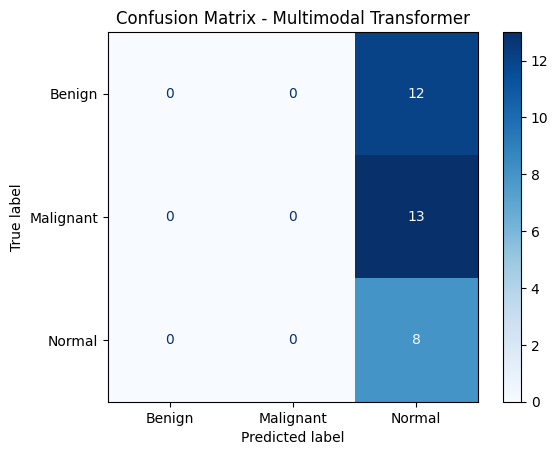

In [50]:

# --- Évaluation sur test
# Prédictions
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Prédictions
y_pred_phase2 = model_phase2.predict([X_img_test_feats, X_meta_test, X_txt_test])
y_pred_classes = np.argmax(y_pred_phase2, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Scores
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names))
print("F1-score:", f1_score(y_true_classes, y_pred_classes, average='weighted'))
print("Accuracy:", accuracy_score(y_true_classes, y_pred_classes))

# ROC AUC
print("ROC AUC:", roc_auc_score(y_test, y_pred_phase2, average=None, multi_class='ovr'))

# Matrice de confusion
cm = confusion_matrix(y_true_classes, y_pred_classes)
ConfusionMatrixDisplay(cm, display_labels=label_names).plot(cmap='Blues')
plt.title("Confusion Matrix - Multimodal Transformer")
plt.show()


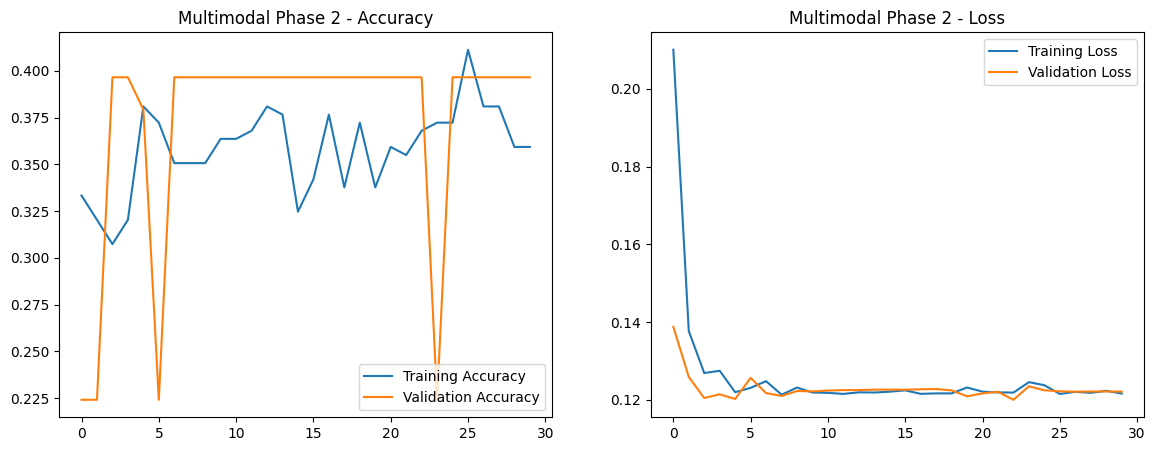

In [51]:
import matplotlib.pyplot as plt

def plot_training_history(history, title="Training History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')

    plt.show()

# Appel pour phase 2
# plot_training_history(history_phase1, title="CNN Phase 1")
plot_training_history(history_phase2, title="Multimodal Phase 2")



In [ ]:
# 📥 Sauvegarde des métriques dans un CSV
import csv
from sklearn.metrics import precision_score, recall_score
from datetime import datetime
import os

# Calcul des métriques
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_true_classes, y_pred_classes)
roc_auc = roc_auc_score(y_test, y_pred_phase2, average=None, multi_class='ovr')  # déjà calculé plus haut

# Heure actuelle
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Nom du fichier script / notebook (si exécuté depuis un fichier)
try:
    filename = os.path.basename(__file__)
except NameError:
    # Si exécuté dans un notebook Jupyter
    filename = "notebook"

# Chemin du CSV
metrics_file = "model_metrics_log.csv"

# Vérifie si le fichier existe déjà
file_exists = os.path.isfile(metrics_file)

# Sauvegarde en ajoutant une ligne
with open(metrics_file, mode='a', newline='') as file:
    writer = csv.writer(file)
    if not file_exists:
        # Écrire l'en-tête si le fichier est nouveau
        writer.writerow(["timestamp", "filename", "precision", "recall", "f1_score", "accuracy", "roc_auc"])
    writer.writerow([timestamp, filename, precision, recall, f1, accuracy, roc_auc])


/home/light/miniforge3/envs/pytorch/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
